# Minimum-area ellipse bounding an isovist: towards a 2D GIS-based efficient implementation

The purpose of this notebook is to illustrate the method developed in the article entitled *Minimum-area ellipse bounding an isovist: towards a 2D GIS-based efficient implementation* to be published in the [International Journal of Geographical Information Science](https://www.tandfonline.com/toc/tgis20/current). In this article, we present an algorithmic solution - as well as the corresponding software implementation in the context of a Geographic Information System - to determine the minimum-area ellipse bounding any given polygon. In order to present this demonstrator in a progressive way, we proceed in two steps: first, we provide a theoretical dataset to exhibit more precisely the modalities of implementation. In a second step, we present a more complex use case based on real and simulated urban data. In the latter case, we produce a field of isovists associated to a few predefined positions, then calculate the corresponding minimum-area bounding ellipses.

## Pre-requisites: load several modules
These prerequisites require a prior installation of the open source project **t4gpd**. More details about this installation can be found [here]().

In [1]:
import geopandas as gpd, matplotlib.pyplot as plt
from geopandas.geodataframe import GeoDataFrame
from shapely.geometry import Polygon, MultiLineString, MultiPoint, Polygon
from shapely.wkt import loads
from t4gpd.isovist.STIsovistField2D import STIsovistField2D
from t4gpd.morph.geoProcesses.Diameter import Diameter
from t4gpd.morph.geoProcesses.MABE import MABE
from t4gpd.morph.geoProcesses.MABR import MABR
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess

## Minimum-area bounding ellipse for an arbitrarily given dataset
### Create and load the input dataset

In [2]:
geom1 = MultiPoint([(20,40), (40,50), (30,60), (50,70), (40,60), (50,60), (60,70), 
                   (65,77), (80,80), (90,90), (105,97), (120,100), (133,115), 
                   (120,120), (100,110), (90,100), (75,89)])
geom2 = MultiLineString([((129, 61), (162, 78), (151, 61), (175, 71), (171, 57), 
                        (190, 60), (191, 52), (195, 53), (198, 49), (201, 49), 
                        (207, 47)), ((169, 47), (193, 46), (200, 38), (195, 33), 
                                     (192, 40), (196, 38), (192, 43), (173, 39))])
geom3 = Polygon([(151, 102),(163, 118),(166, 108),(174, 116),(176, 108),(188, 117),
                (188, 107),(201, 114),(203, 103),(202, 91),(200, 99),(192, 96),
                (209, 80),(217, 101),(230, 97),(227, 76),(224, 62),(221, 73),
                (214, 67),(216, 75),(209, 72),(198, 86),(151, 102)])

rows = [{'gid':1, 'geometry':geom1}, {'gid':2, 'geometry': geom2},
        {'gid':3, 'geometry': geom3}]
inputGdf = GeoDataFrame(rows, crs='EPSG:2154')

### Evaluate the corresponding Minimum-Area Bounding Ellipses (MABE)

In [3]:
ellipse = STGeoProcess(MABE(), inputGdf).run()

### Plot the input dataset and the corresponding MABE

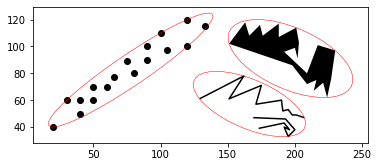

In [4]:
basemap = inputGdf.plot(color='black')
ellipse.boundary.plot(ax=basemap, edgecolor='red', linewidth=0.5)
plt.show()

## A more complex use case based on real and simulated urban data: Evaluation of minimum-area ellipses for a set of isovists in Paris 9$^\textrm{th}$ borough
Let's start by loading the footprints of buildings in this Parisian borough as well as the point of view from which we want to generate the isovist.

In [5]:
buildings  = gpd.read_file('./data-p9/buildings.shp')
viewpoints = gpd.read_file('./data-p9/nodes.shp').query('gid == 384')

Let's generate the corresponding isovist field. This field consists of a single isovist:

In [6]:
_, isovist = STIsovistField2D(buildings, viewpoints, nRays=360, 
                              rayLength=200.0).run()

Let's assess the corresponding Minimum-Area Bounding Ellipse (MABE), Minimum-Area Bounding Rectangle (MABR), and diameter:

In [7]:
ellipse   = STGeoProcess(MABE(),   isovist).run()
rectangle = STGeoProcess(MABR(),   isovist).run()
diameter  = STGeoProcess(Diameter, isovist).run()

Let's determine the axis of the minimum-area bounding ellipse from the MABE data:

In [8]:
ellipseAxis = ellipse.copy()
ellipseAxis['geometry'] = ellipseAxis['mabe_axis'].apply(loads)

Zoom on a given region of interest (i.e. 50 m around the isovist); then plot the input dataset, the corresponding MABR, MABE, MABE major axis, and diameter:

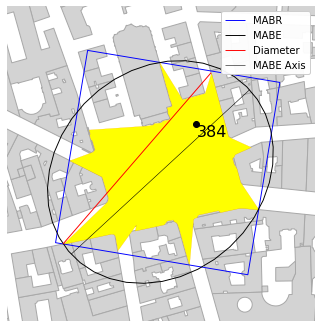

In [9]:
delta = 50.0
minx, miny, maxx, maxy = isovist.total_bounds
minx, miny, maxx, maxy = (minx - delta, miny - delta, maxx + delta, maxy + delta)

_, basemap = plt.subplots(figsize=(0.7*8.26, 0.7*8.26))
buildings.plot(ax=basemap, color='lightgray', edgecolor='darkgray')
isovist.plot(ax=basemap, color='yellow', edgecolor='orange', linewidth=0.2)
rectangle.boundary.plot(ax=basemap, edgecolor='blue', linewidth=0.95, label='MABR')
ellipse.boundary.plot(ax=basemap, edgecolor='black', linewidth=0.95, label='MABE')
diameter.plot(ax=basemap, edgecolor='red', linewidth=0.95, label='Diameter')
ellipseAxis.plot(ax=basemap, edgecolor='black', linewidth=0.55, label='MABE Axis')
viewpoints.plot(ax=basemap, color='black', marker='o')
viewpoints.apply(lambda x: basemap.annotate(
        s=x['gid'], xy=x.geometry.coords[0],
        color='black', size=16, ha='left', va='top'), axis=1)
plt.axis([minx, maxx, miny, maxy])
plt.axis('off')
plt.legend(loc = 'upper right', framealpha=0.95)
plt.show()